In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chaosmagpy.model_utils import design_gauss, power_spectrum
from chaosmagpy.data_utils import timestamp
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from alberte_klara_lib import do_design, do_design_timetrend, plot_map_three, plot_map_one, get_gausscoeff_timetrend, plot_hist_withzoom, plot_power_spectrum, plot_difference_F
from alberte_klara_lib import n_int_max, n_ext_max, theta_grid, phi_grid, radius_Earth, radius_CMB
import os

In [2]:
data_dst = "ready_swarm_data\swarmALL_dark_quiet.txt"
data = pd.read_table(data_dst, delimiter = ",")
data

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\klara\AppData\Local\Temp\ipykernel_14216\1059072173.py:1: SyntaxWarning: invalid escape sequence '\s'
  data_dst = "ready_swarm_data\swarmALL_dark_quiet.txt"


time_stamp      radius       colat         lon             X  \
0       8637.034722  6857.71465   57.854683  -97.671338  18463.032300   
1       8637.035417  6858.44381   61.671862  -97.684158  19485.054900   
2       8637.036111  6859.17873   65.488909  -97.713543  20371.329200   
3       8637.036806  6859.91378   69.305713  -97.756040  21121.203500   
4       8637.037500  6860.64352   73.122179  -97.808814  21730.641800   
...             ...         ...         ...         ...           ...   
634202  8636.928310  6870.37982  166.395614  109.972052  -5452.695416   
634203  8636.929005  6870.35215  162.649197  112.241359  -4153.820561   
634204  8636.929699  6870.30656  158.881935  113.635552  -2538.131414   
634205  8636.930394  6870.24148  155.103130  114.550005   -685.165622   
634206  8636.931088  6870.15521  151.317180  115.173935   1327.454411   

                  Y             Z  flags_b  flags_q      dDst      Hp30  \
0        930.535900  32934.677100        0        0  2.999840  2.333667   
1        994.463400  30215.053700        0        0  2.949844  2.367000   
2       1071.066900  27350.914400        0        0  2.899848  2.400333   
3       1167.476600  24367.357600        0        0  2.849852  2.433667   
4       1285.545700  21286.119700        0        0  2.799856  2.467000   
...             ...           ...      ...      ...       ...       ...   
634202 -7029.085315 -46574.496919        9        0  2.456235  3.000000   
634203 -6283.441418 -48042.093246        9        0  2.572892  3.000000   
634204 -5594.890157 -49251.759573        9        0  2.689549  3.000000   
634205 -4948.775940 -50147.510610        9        0  2.806207  3.000000   
634206 -4308.386563 -50696.484862        9        0  2.922864  3.000000   

                   F      B_radius       B_theta        B_phi  
0       37768.272590 -32934.677100 -18463.032300   930.535900  
1       35966.731739 -30215.053700 -19485.054900   994.463400  
2       34120.532765 -27350.914400 -20371.329200  1071.066900  
3       32268.194175 -24367.357600 -21121.203500  1167.476600  
4       30446.220006 -21286.119700 -21730.641800  1285.545700  
...              ...           ...           ...          ...  
634202  47416.491761  46574.496919   5452.695416 -7029.085315  
634203  48628.989140  48042.093246   4153.820561 -6283.441418  
634204  49633.463792  49251.759573   2538.131414 -5594.890157  
634205  50395.760294  50147.510610    685.165622 -4948.775940  
634206  50896.541212  50696.484862  -1327.454411 -4308.386563  

[634207 rows x 15 columns]

## Static field modelling

In [3]:
nm_static = (n_int_max + 1)**2 - 1 + (n_ext_max + 1)**2 - 1
nm_internal = (n_int_max + 1)**2 - 1
nm_external = (n_ext_max + 1)**2 - 1
n_obs = len(data)

# lhs and rhs of lst sq prb will have to be constructed bit by bit
# allocating these in memory
lhs = np.zeros((nm_static, nm_static)) # G.T@G
rhs = np.zeros((nm_static,)) # G.T@d

# taking 10k data point at a time (sub matrix, chunk of data, G_sub) - but still all model parameters
i = 0
while (i <= n_obs - 10*10**3):
    i10k = i + 10*10**3

    G_int = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_int_max)))
    G_ext = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_ext_max, source = 'external')))
    G = np.hstack((G_int, G_ext))
    lhs += G.T@G

    d = np.hstack((data['B_radius'].iloc[i:i10k], data['B_theta'].iloc[i:i10k], data['B_phi'].iloc[i:i10k]))
    rhs += G.T@d
    i += 10*10**3

G_int = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_int_max)))
G_ext = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_ext_max, source = 'external')))
G = np.hstack((G_int, G_ext))
lhs += G.T@G

d = np.hstack((data['B_radius'].iloc[i:], data['B_theta'].iloc[i:], data['B_phi'].iloc[i:]))
rhs += G.T@d


m = np.linalg.solve(lhs, rhs)

m_int_static = m[:-((n_ext_max + 1)**2 - 1)]
m_ext_static = m[-((n_ext_max + 1)**2 - 1):]

# np.savetxt(os.path.join('ready_swarm_data', 'int_model_static_parameters'), m_int_static)
# np.savetxt(os.path.join('ready_swarm_data', 'ext_model_static_parameters'), m_ext_static)

In [4]:
# Predicted field at Swarm altitude
G_pred_static_radius, G_pred_static_theta, G_pred_static_phi = do_design(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max)

b_pred_static_radius = G_pred_static_radius @ m
b_pred_static_theta = G_pred_static_theta @ m
b_pred_static_phi = G_pred_static_phi @ m

# field intensity
F_pred_static = np.sqrt(b_pred_static_radius**2 + b_pred_static_theta**2 + b_pred_static_phi**2)

# Residuals
residuals_r_static = data['B_radius'] - b_pred_static_radius
residuals_t_static = data['B_theta'] - b_pred_static_theta
residuals_p_static = data['B_phi'] - b_pred_static_phi

# Residuals between model-predicted field and measured field

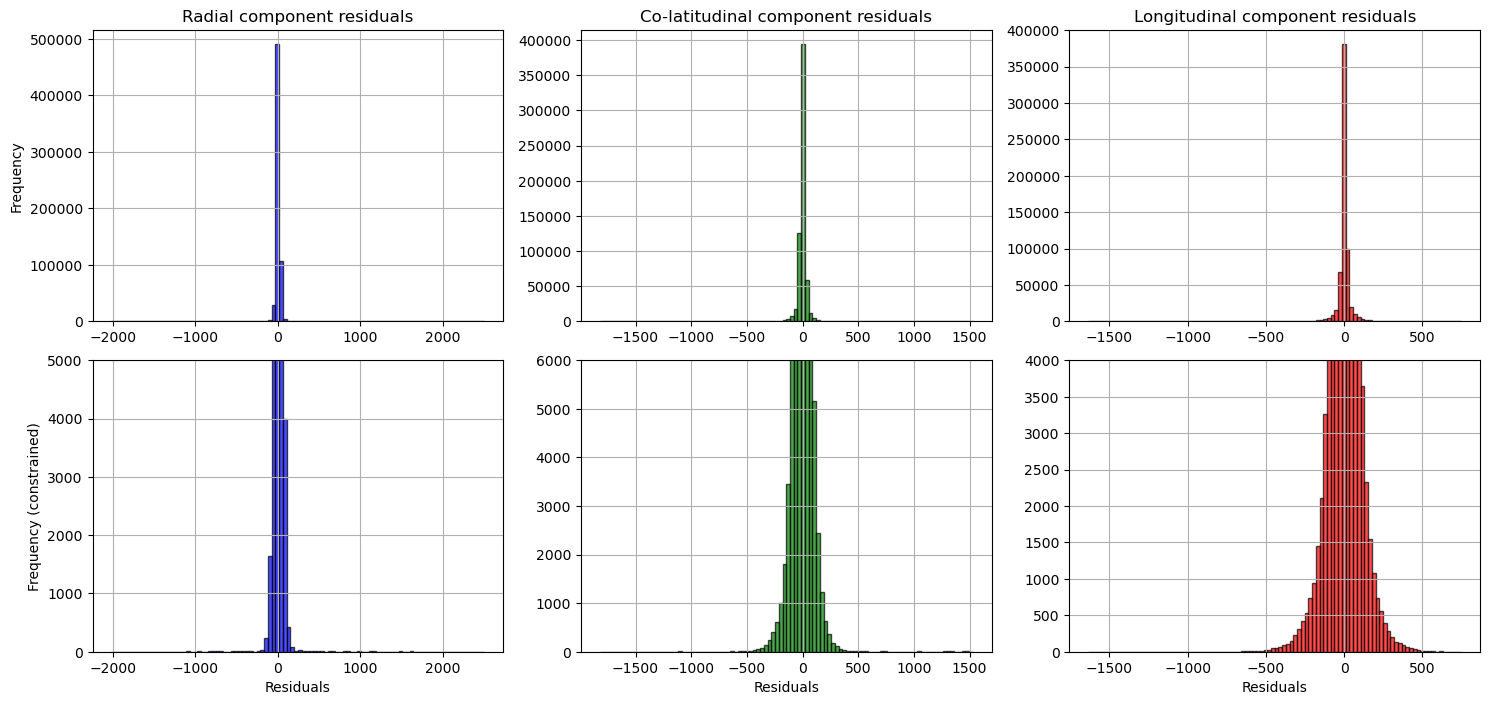

In [34]:
plot_hist_withzoom(residuals_r_static, residuals_t_static, residuals_p_static, 5000, 6000, 4000, 'swarm')

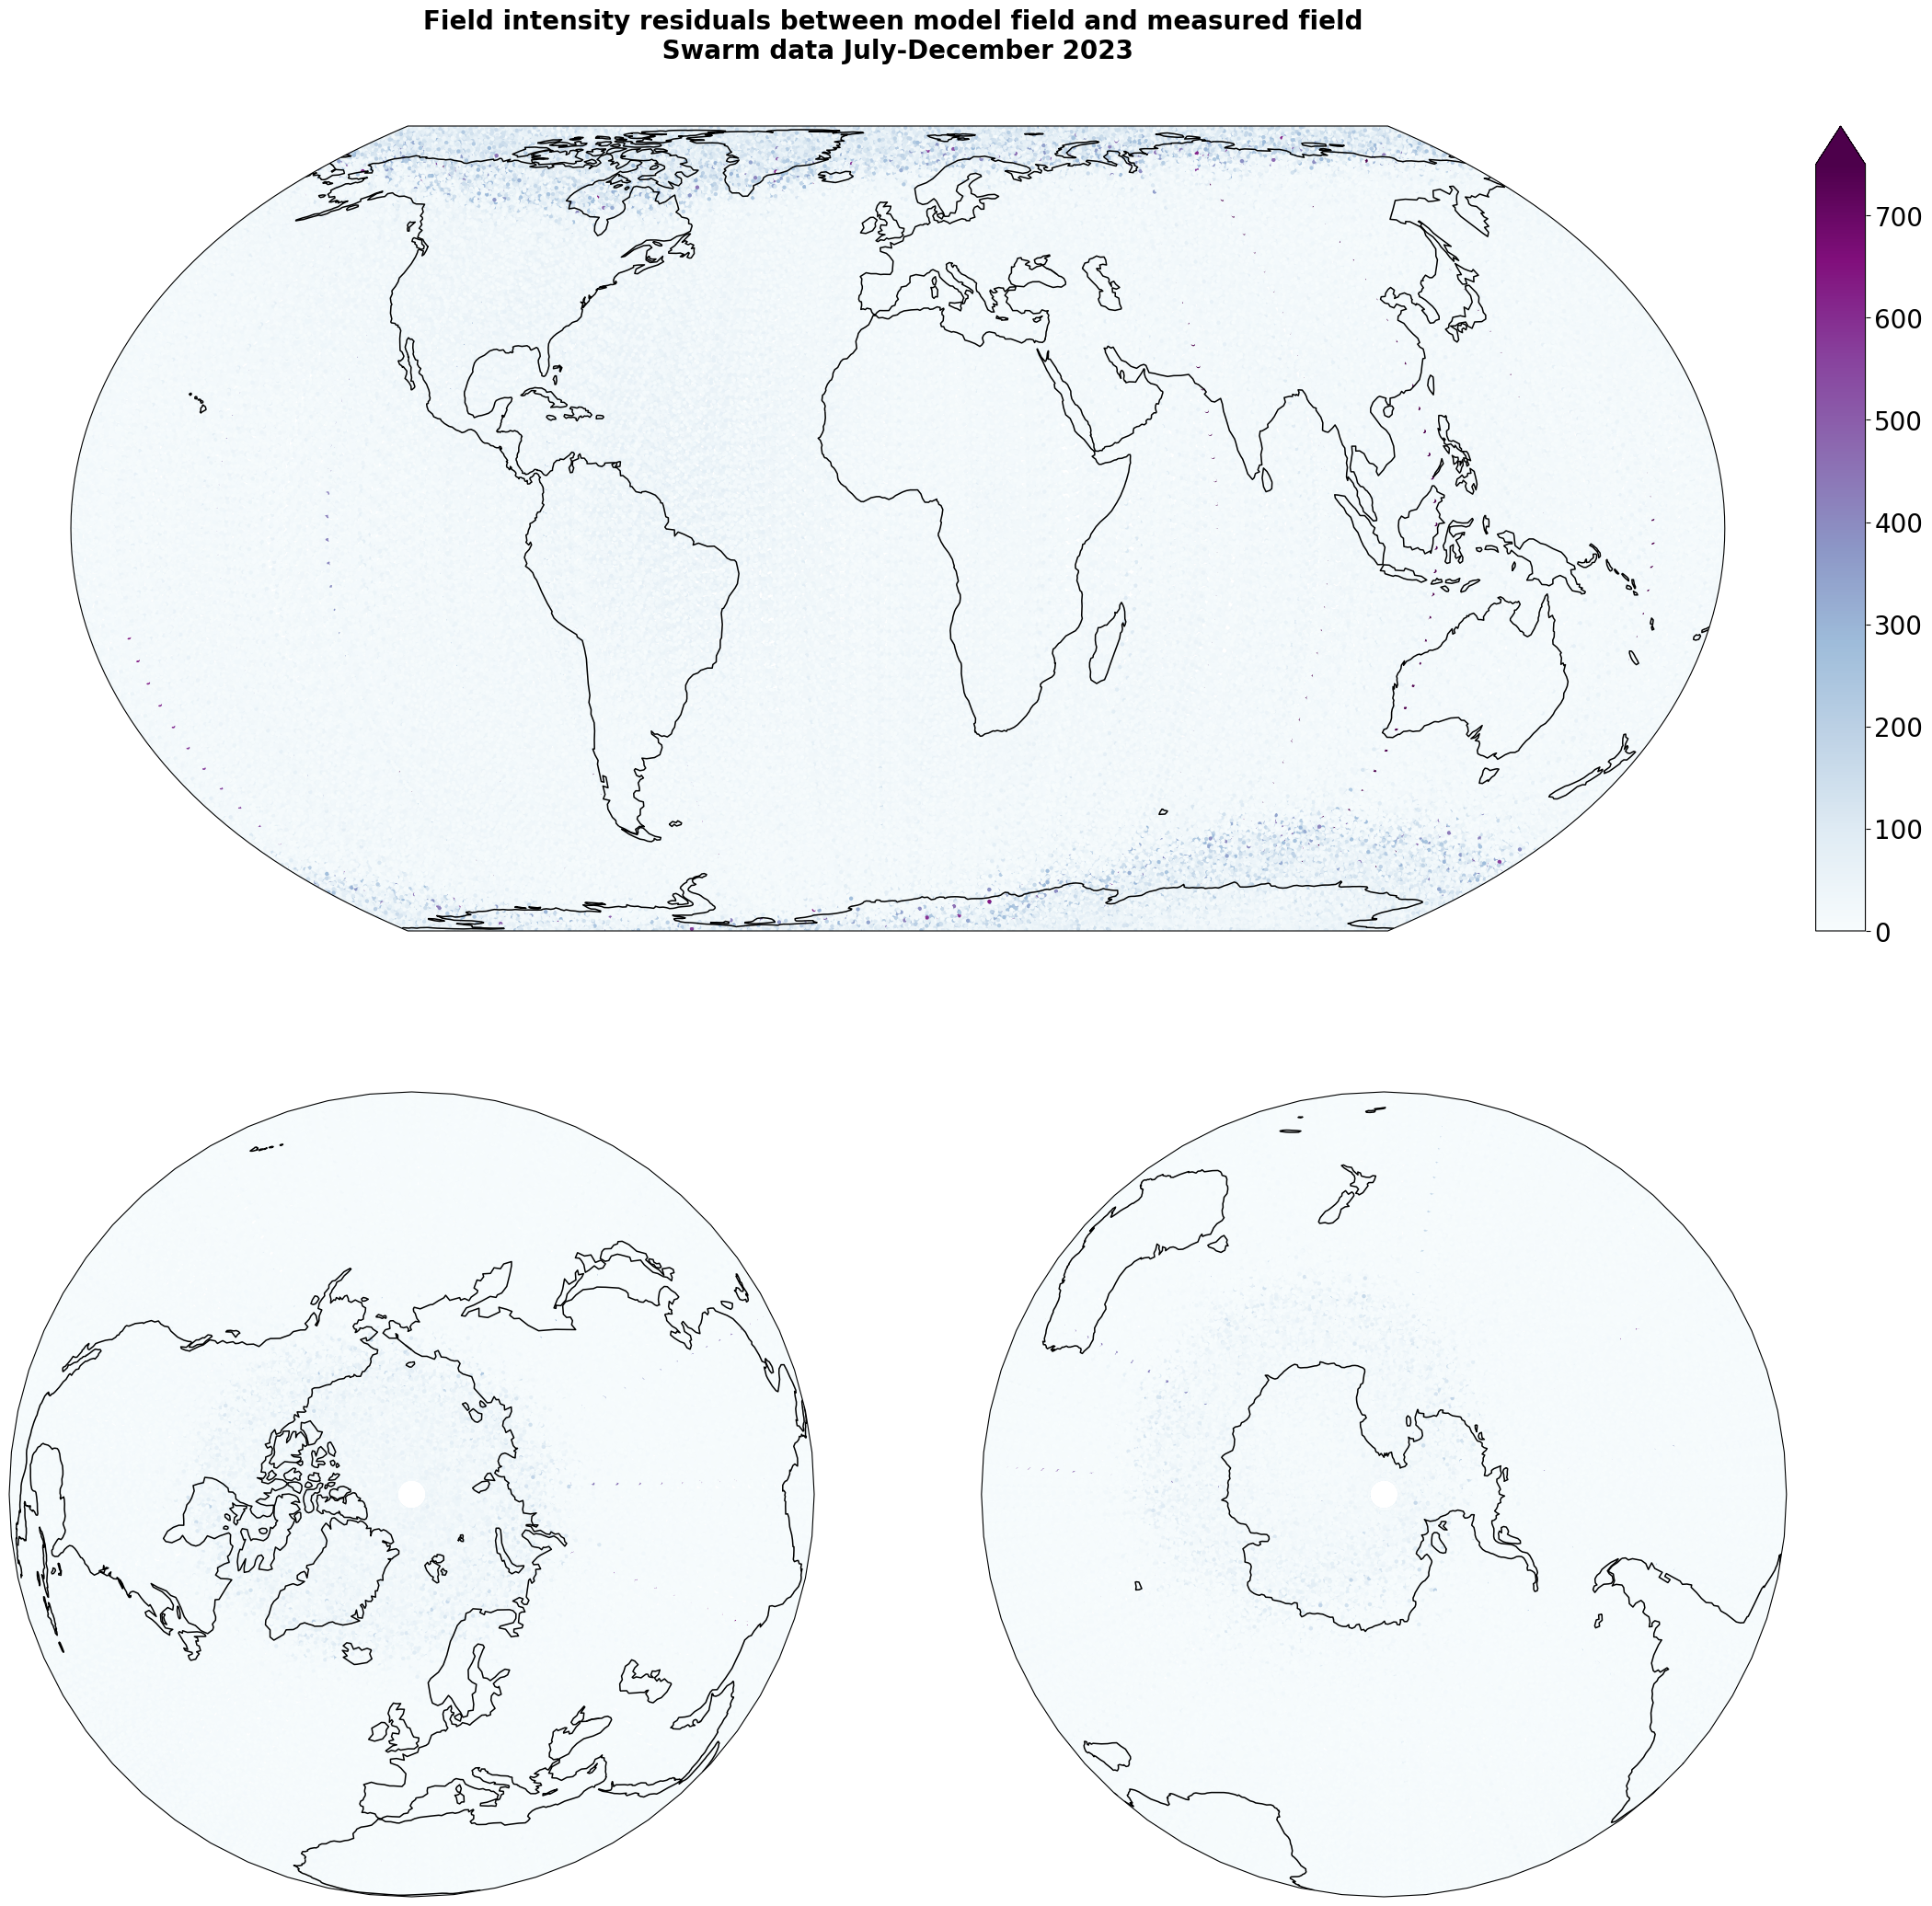

In [7]:
# Intensity of residuals on map
F_residuals = np.sqrt(residuals_r_static**2 + residuals_t_static**2 + residuals_p_static**2)

# plot_map_three(F_residuals, data['lon'], data['colat'], 'Swarm', 'Field intensity residuals between model field and measured field', 'Residuals [nT]', scatter_size = 10, clim=[0, 750], colors='BuPu')

# Model with temporal gradient - linear trend of secular variation
Derive secular coefficients:
gnm = gnm(t0) + g'nm(t0)*(t - t0)

In [9]:
# t0 = t_start + (t_end - t_start)/2
t0_exact = min(data['time_stamp'].values) + (max(data['time_stamp'].values) - min(data['time_stamp'].values))/2

# must manipulate with time stamp because data points have been removed
t = np.floor(round(data['time_stamp'], 2)*10)/10

t0_idx = np.argmin(np.abs(t - t0_exact))
t0 = data['time_stamp'].iloc[t0_idx]
print("\nt0 = " + str(t0) + " at index " + str(t0_idx) + "\ndate in np datetime64 format: " + str(timestamp(t0)))

# temporal gradient
data['time_grad'] = data['time_stamp'] - t0

np.savetxt(os.path.join('ready_swarm_data', 'time_grad_frame'), [min(data['time_grad'].values), max(data['time_grad'].values)])


t0 = 8583.503032407407 at index 178834
date in np datetime64 format: 2023-07-02T12:04:22.000000


In [50]:
m = get_gausscoeff_timetrend(data, n_int_max, n_ext_max)

In [51]:
m_static = m[:nm_static]
m_sec = m[-(nm_internal):]
m_ext = m[(n_int_max + 1)**2 - 1:]

np.savetxt(os.path.join('ready_swarm_data', 'static_model_parameters'), m_static)
np.savetxt(os.path.join('ready_swarm_data', 'model_parameters'), m)


# Look at dipole coefficients
dipole_coef = np.empty((len(data['time_grad']), 3))
for i in range(3):
    dipole_coef[:, i]= m_static[i] + m_sec[i]*data['time_grad'].values # g = g0 + g'(t0)(t-t0)

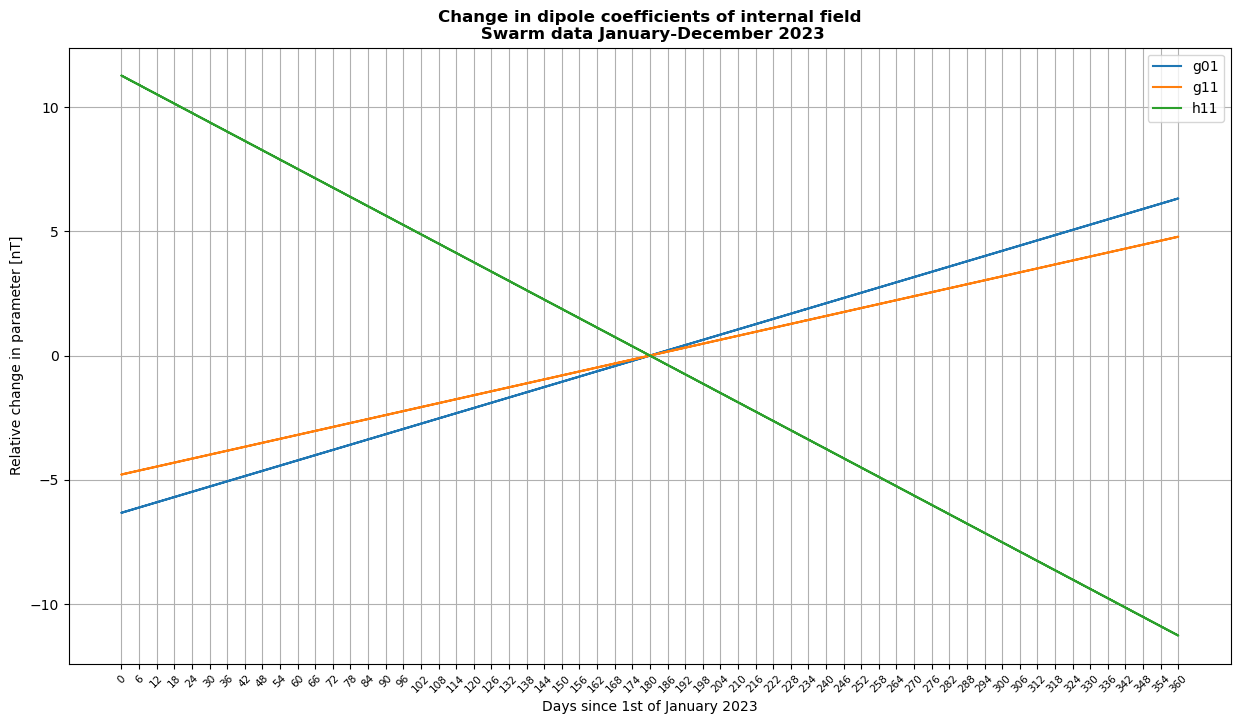

In [27]:
no_days_swarm = round(max(data['time_stamp']) - min(data['time_stamp']))

plt.figure(figsize=(15, 8))

plt.plot(data['time_grad'], m_sec[0]*data['time_grad'].values, label='g01')
plt.plot(data['time_grad'], m_sec[1]*data['time_grad'].values, label='g11')
plt.plot(data['time_grad'], m_sec[2]*data['time_grad'].values, label='h11')
plt.legend()
plt.grid()
tick_positions = np.linspace(min(data['time_grad']), max(data['time_grad']), len(range(no_days_swarm)[::6]))
plt.xticks(tick_positions, range(no_days_swarm)[::6], fontsize = 7.5, rotation = 45)
plt.xlabel('Days since 1st of January 2023')
plt.ylabel('Relative change in parameter [nT]')
plt.title('Change in dipole coefficients of internal field\n Swarm data January-December 2023', weight = 'bold', fontsize = 12)
plt.show()


In [31]:
# # Predicted field at measurement coordinates
G_pred_radius1, G_pred_theta1, G_pred_phi1 = do_design_timetrend(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max, data['time_grad'].values)

b_pred_radius1 = G_pred_radius1 @ m
b_pred_theta1 = G_pred_theta1 @ m
b_pred_phi1 = G_pred_phi1 @ m

b_pred_radius2 = G_pred_radius1 @ m
b_pred_theta2 = G_pred_theta1 @ m
b_pred_phi2 = G_pred_phi1 @ m


Compare residuals between static field model and model including secular variations

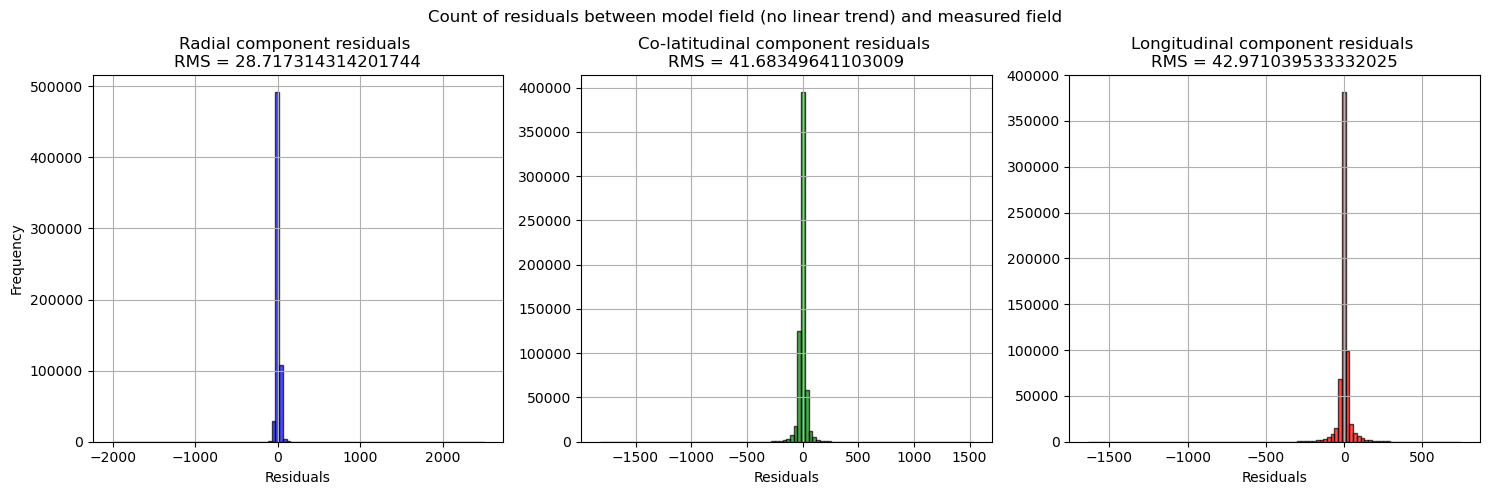

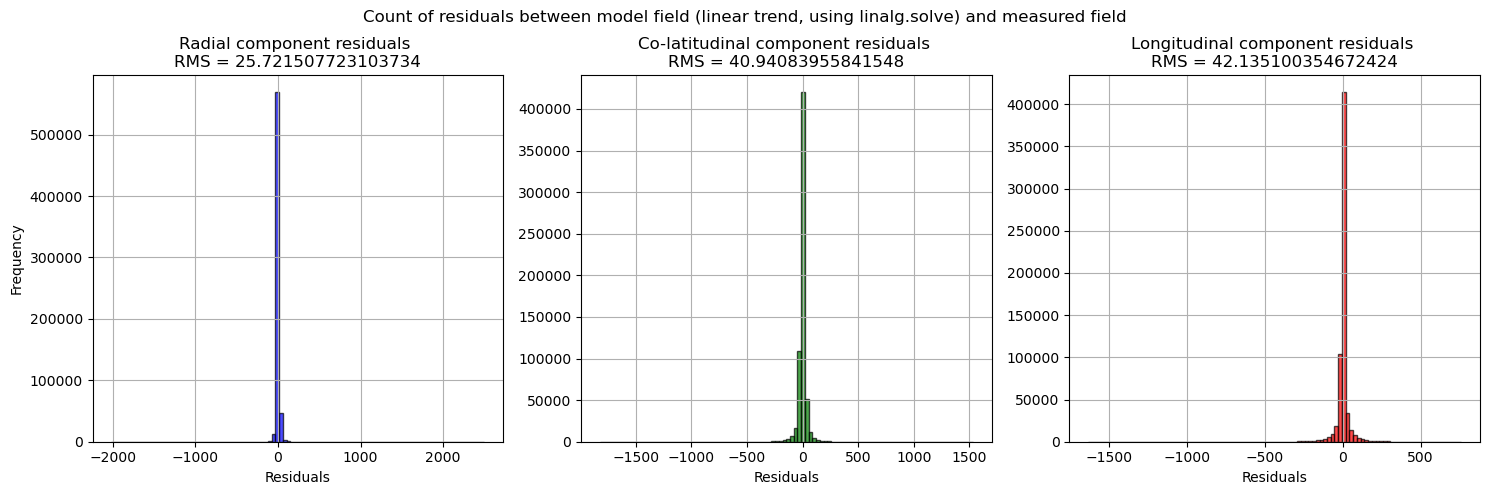

In [32]:
# Residuals
# residuals_r = data['B_radius'] - b_pred_radius
# residuals_t = data['B_theta'] - b_pred_theta
# residuals_p = data['B_phi'] - b_pred_phi

residuals_r1 = data['B_radius'] - b_pred_radius1
residuals_t1 = data['B_theta'] - b_pred_theta1
residuals_p1 = data['B_phi'] - b_pred_phi1

residuals_r2 = data['B_radius'] - b_pred_radius2
residuals_t2 = data['B_theta'] - b_pred_theta2
residuals_p2 = data['B_phi'] - b_pred_phi2


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_r_static**2))))
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
axs[1].set_title('Co-latitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_t_static**2))))
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
axs[2].set_title('Longitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_p_static**2))))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field (no linear trend) and measured field')

plt.show()


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r1, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_r1**2))))
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t1, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
axs[1].set_title('Co-latitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_t1**2))))
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p1, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
axs[2].set_title('Longitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_p1**2))))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field (linear trend, using linalg.solve) and measured field')

plt.show()

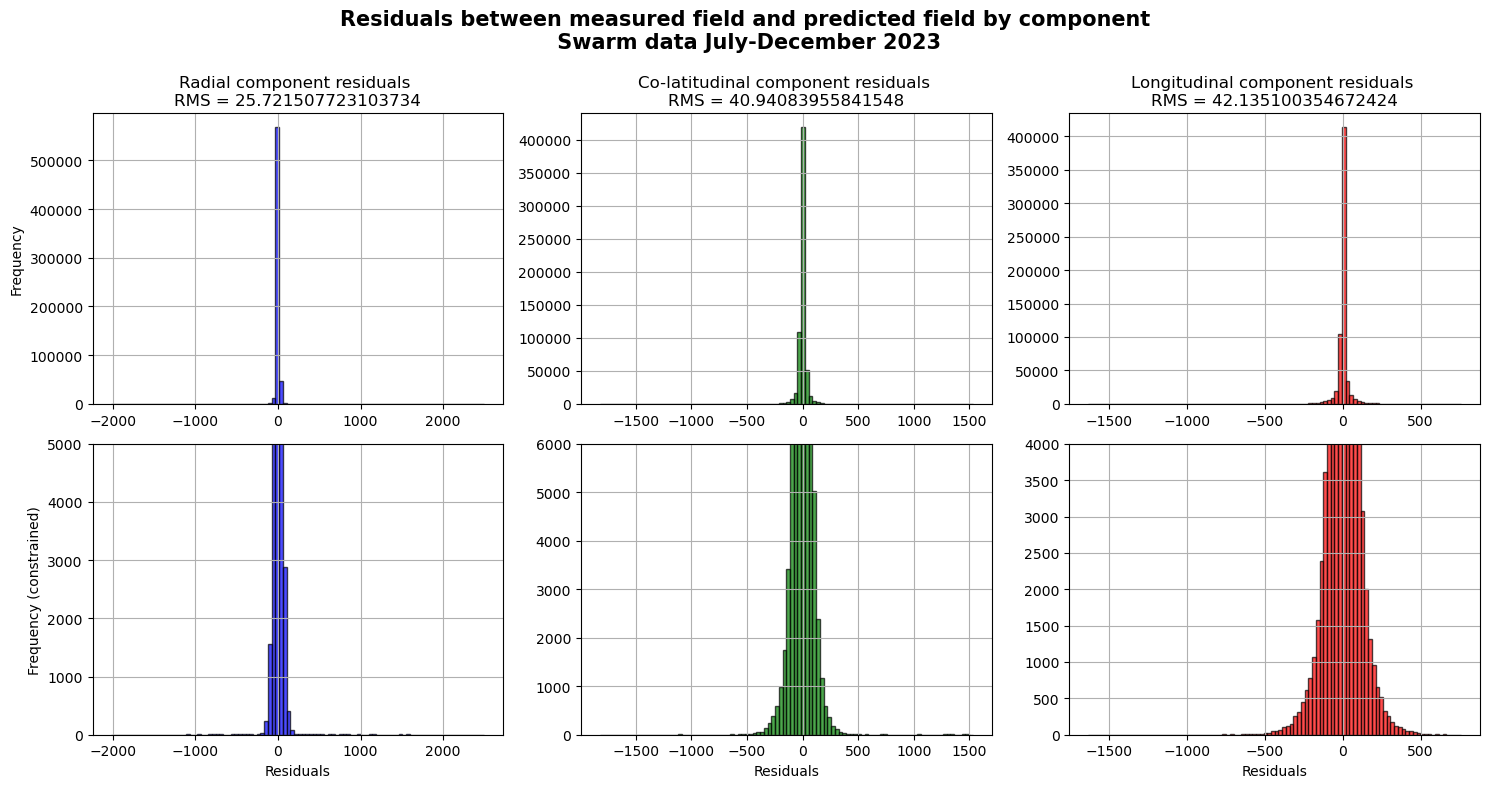

In [52]:
plot_hist_withzoom(residuals_r1, residuals_t1, residuals_p1, 5000, 6000, 4000, 'swarm')

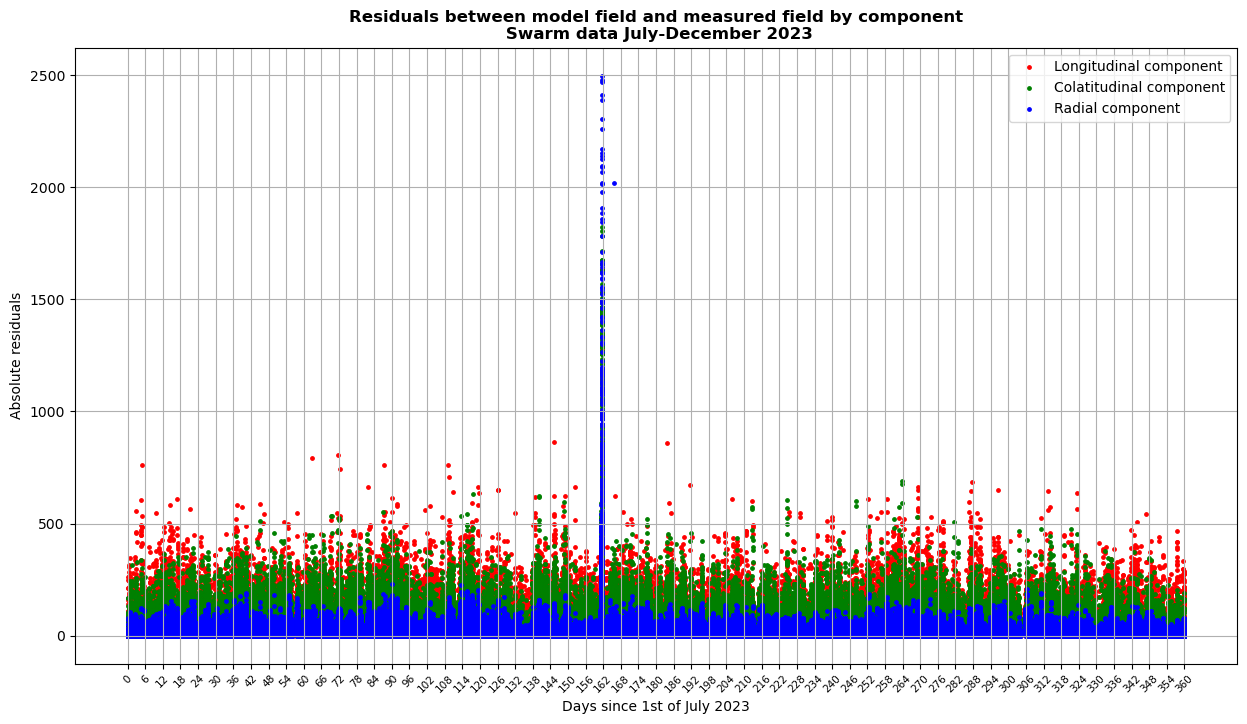

In [34]:
plt.figure(figsize=(15,8))
plt.scatter(data['time_stamp'], abs(residuals_p2), label = 'Longitudinal component', color = 'red', s = 6)
plt.scatter(data['time_stamp'], abs(residuals_t2), label = 'Colatitudinal component', color = 'green', s = 6)
plt.scatter(data['time_stamp'], abs(residuals_r2), label = 'Radial component', color = 'blue', s = 6)
plt.legend()
plt.grid()
plt.ylabel('Absolute residuals')
tick_positions = np.linspace(min(data['time_stamp']), max(data['time_stamp']), len(range(no_days_swarm)[::6]))
plt.xticks(tick_positions, range(no_days_swarm)[::6], fontsize = 7.5, rotation = 45)
plt.xlabel('Days since 1st of January 2023')
plt.title('Residuals between model field and measured field by component\n Swarm data January-December 2023', weight = 'bold', fontsize = 12)
plt.show()

## Plot the secular variation [nT/yr]

then d = G*m'(t0)

not d = G*m'(t0)(t-t0) (think units)

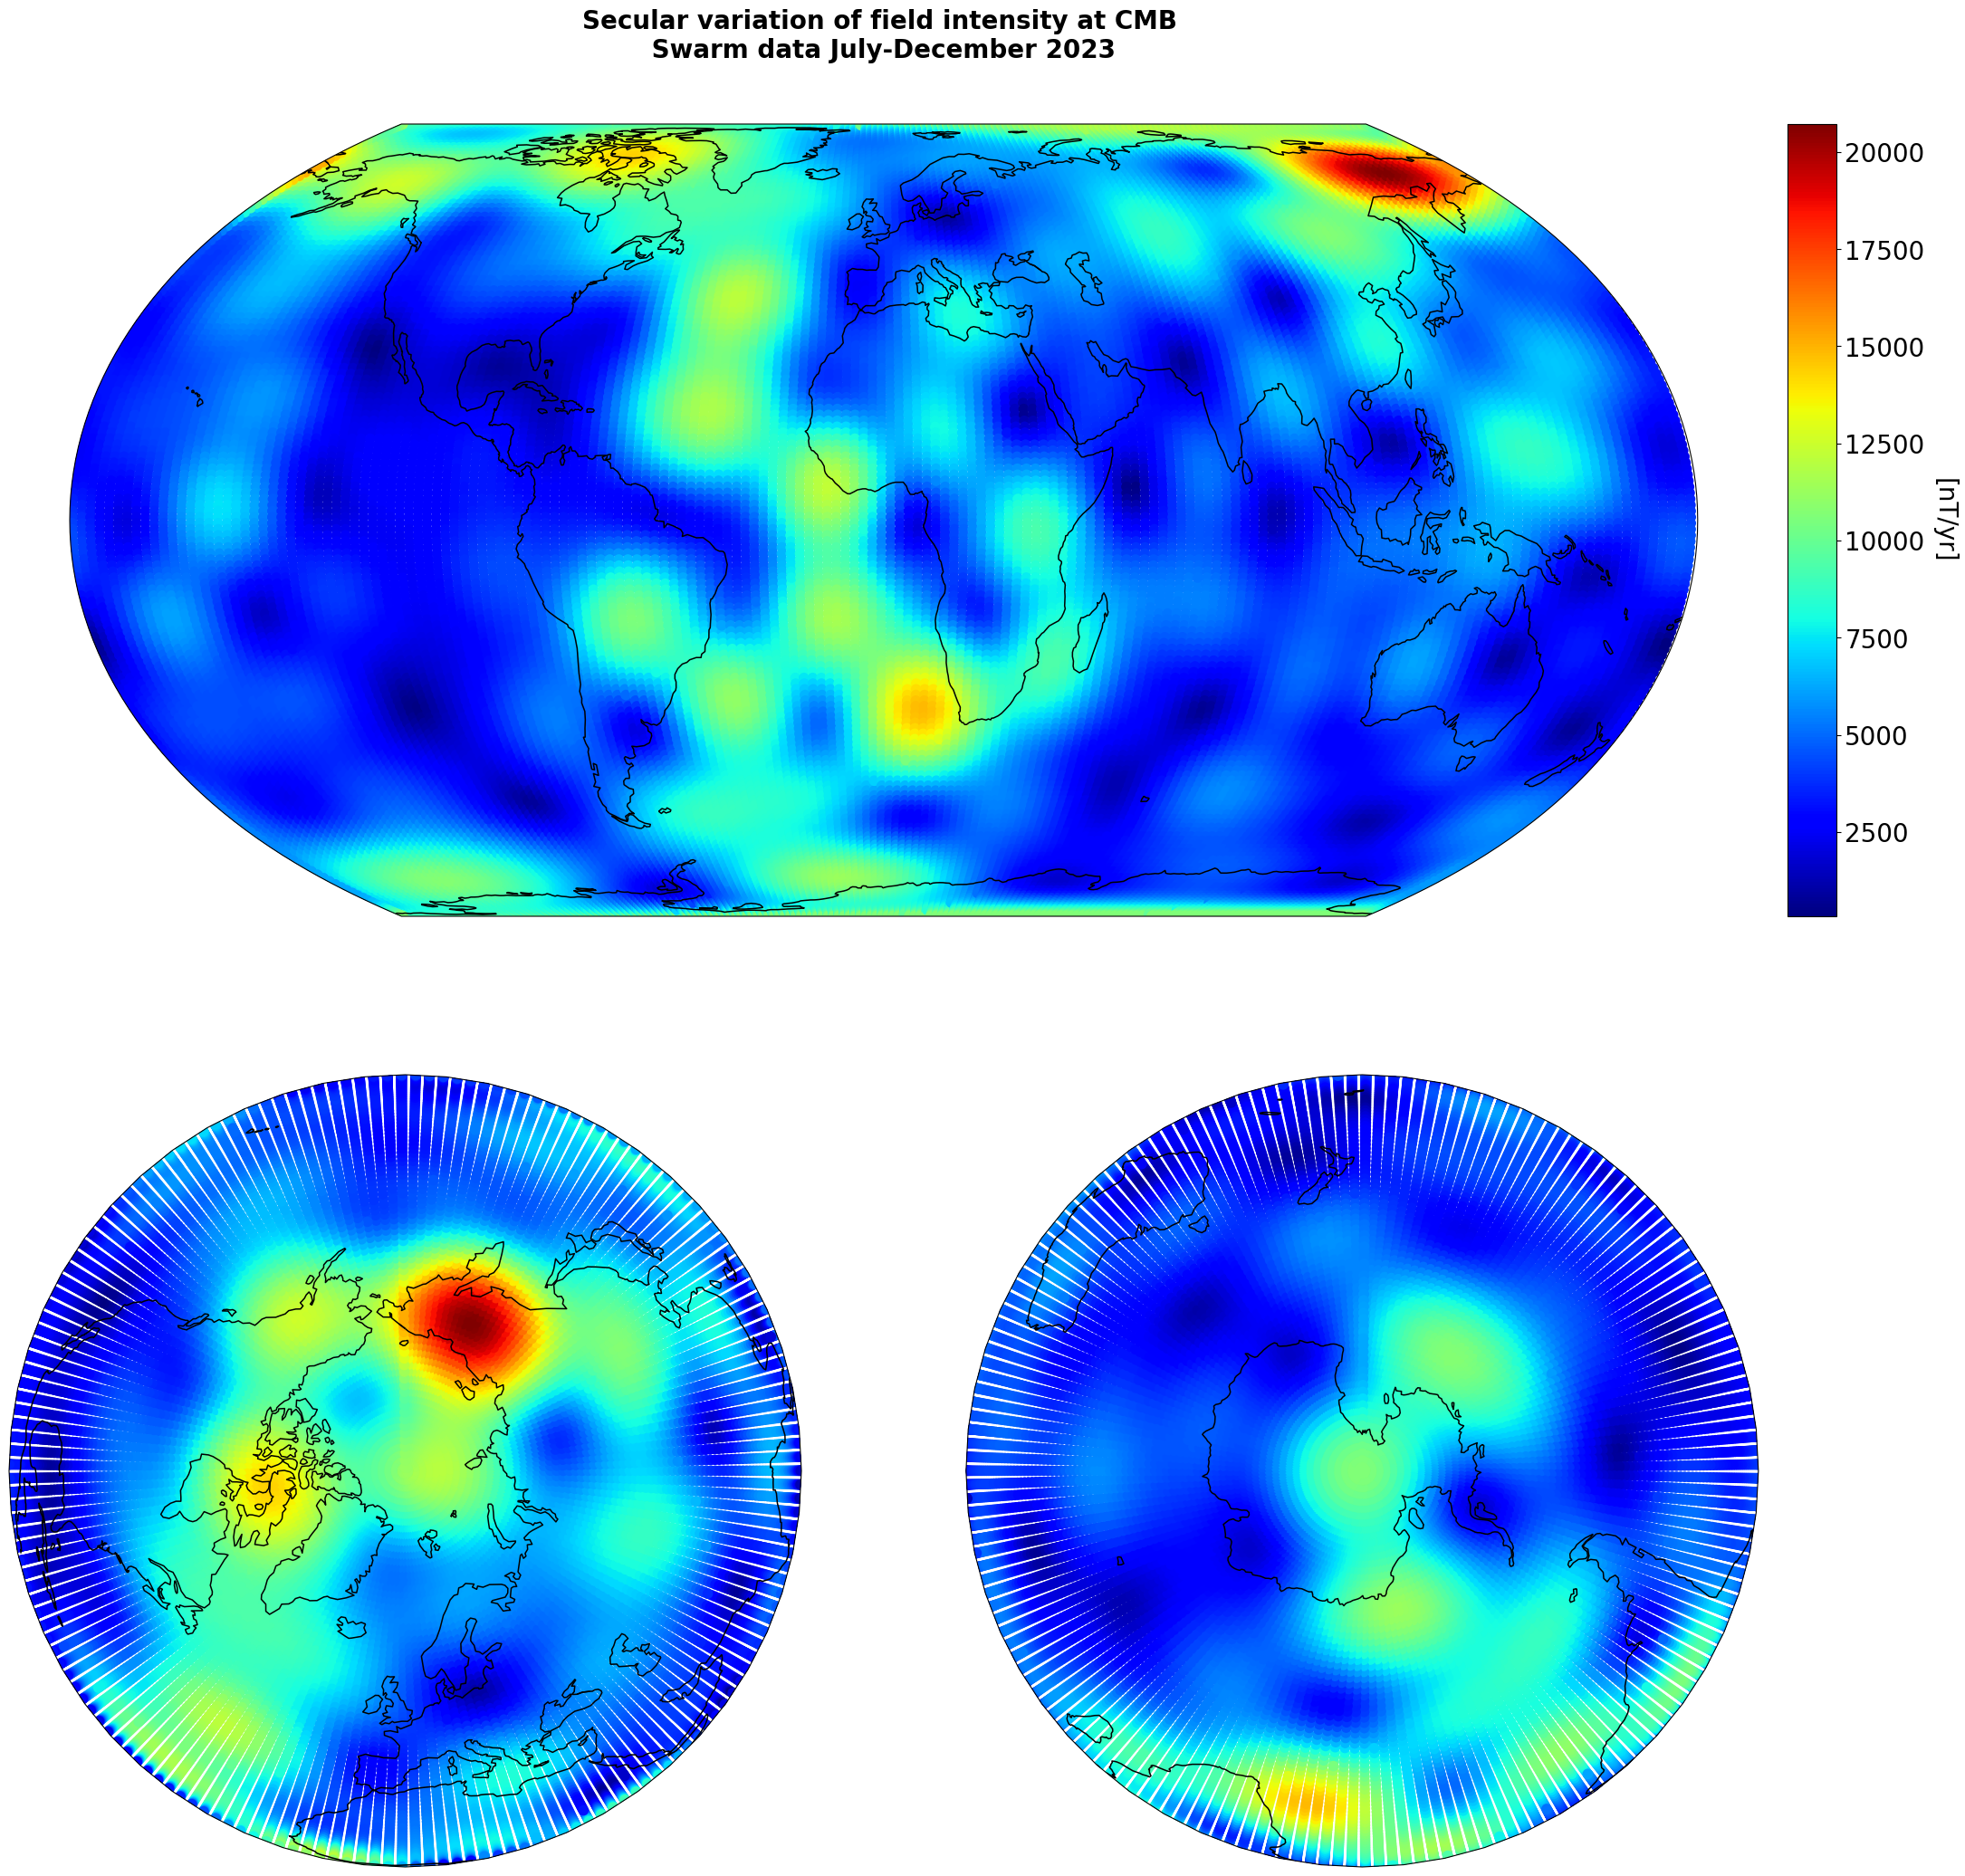

In [44]:
n_int_max = 10
n_ext_max = 1
nm_internal = (n_int_max + 1)**2 - 1
nm_static = (n_int_max + 1)**2 - 1 + (n_ext_max + 1)**2 - 1

Gr, Gt, Gp = do_design(radius_CMB, theta_grid, phi_grid, n_int_max, n_ext_max) # Normal design to not have (t-t0)
m = get_gausscoeff_timetrend(data, n_int_max, n_ext_max)


b_pred_radius2 = Gr[:, :nm_internal] @ m[nm_static:]*365
b_pred_theta2 = Gt[:, :nm_internal] @ m[nm_static:]*365
b_pred_phi2 = Gp[:, :nm_internal] @ m[nm_static:]*365


F_sec = np.sqrt(b_pred_radius2**2 + b_pred_theta2**2 + b_pred_phi2**2)

plot_map_three(F_sec, phi_grid, theta_grid, 'Swarm', 'Secular variation of field intensity at CMB', '[nT/yr]')